# Feature Evolution with Phase

This notebook explores the evolution of feature properties (e.g., pEW and velocities) as a function of phase.


In [1]:
from collections import OrderedDict
from pathlib import Path
from warnings import warn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MultipleLocator
from scipy.stats.stats import pearsonr
from sndata.csp import DR3
from sndata.sdss import Sako18Spec
from sndata.utils import convert_to_jd


In [2]:
curr_dir = Path('.').resolve() 

results_dir = curr_dir.parent / 'results'
fig_dir = curr_dir / 'figures' / 'phase_evolution'
fig_dir.mkdir(parents=True, exist_ok=True)


In [3]:
dr3 = DR3()
dr3.download_module_data()

sako_18_spec = Sako18Spec()
sako_18_spec.download_module_data()


In [4]:
feature_alias = {
    'pW1': 'Ca ii H&K',
    'pW2': 'Si ii λ4130',
    'pW3': 'Mg ii, Fe ii',
    'pW4': 'Fe ii, Si ii',
    'pW5': 'S ii λ5449, λ5622',
    'pW6': 'Si ii λ5972',
    'pW7': 'Si ii λ6355',
    'pW8': 'Ca ii IR triplet'}

## Reading in Data

In [5]:
csp_table_3 = dr3.load_table(3).to_pandas(index='SN')


@np.vectorize
def get_csp_t0(obj_id):
    """Get the t0 value for CSP targets

    Args:
        obj_id (str): The object identifier

    Returns:
        The time of B-band maximum in units of
    """
    
    # Unknown object ID
    if obj_id not in csp_table_3.index:
        return np.nan

    t0_mjd = csp_table_3.loc[obj_id]['T(Bmax)']

    # Known object Id with unknown peak time
    if np.isnan(t0_mjd):
        return np.nan

    return convert_to_jd(t0_mjd)


In [6]:
sdss_master_table = sako_18_spec.load_table('master').to_pandas(index='CID')


@np.vectorize
def get_sdss_t0(obj_id):
    """Get the t0 value for CSP targets

    Args:
        obj_id (str): The object identifier

    Returns:
        The time of B-band maximum in units of
    """
    
    obj_id = str(obj_id)
    
    # Unknown object ID
    if obj_id not in sdss_master_table.index:
        return np.nan

    t0_mjd = sdss_master_table.loc[obj_id]['PeakMJDSALT2zspec']

    # Known object Id with unknown peak time
    if np.isnan(t0_mjd):
        return np.nan

    return convert_to_jd(t0_mjd)


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: TableReplaceWarning: converted column 'ndofSALT2zspec' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: TableReplaceWarning: converted column 'ndofMLCS2k2zspec' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: TableReplaceWarning: converted column 'lcqualityIaPSNIDzspec' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: TableReplaceWarning: converted column 'lcqualityIbcPSNIDzspec' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: TableReplaceWarning: converted column 'lcqualityIIPSNIDzs

In [7]:
def branch_classification(pipeline_data):
    """Return a series with the Branch classification for each objects
    
    Args:
        pipeline_data (DataFrame): Data that has been read from a pipeline output file
        
    Returns:
        A Pandas Series object
    """
    
    peak_vals = pipeline_data[pipeline_data.is_peak]
    df = peak_vals.loc['pW6'].join(
        peak_vals.loc['pW7'], 
        lsuffix='_pw6', 
        rsuffix='_pw7', 
        on='obj_id')

    classifications = np.full_like(df.index, 'unknown', dtype='U10')
    classifications[df.pew_pw6 > 30] = 'CL'
    classifications[(df.pew_pw7 > 105) & (df.pew_pw6 < 30)] = 'BL'
    classifications[df.pew_pw7 < 70] = 'SS'
    classifications[(70 <= df.pew_pw7) & (df.pew_pw7 <= 105) & (df.pew_pw6 <= 30)] = 'CN'
    return pd.Series(classifications, index=df.index, name='branch_type')


In [8]:
def read_in_pipeline_result(path, survey, drop_flagged=False):
    """Read pEW values from analysis pipeline file
    
    Adds columns for Branch classifications determined by the
    measured pEW values and spectral subtypes determined from 
    CSP DR1.
    
    Args:
        path          (str): Path of the file to read
        survey        (str): Read in data for either `csp` or `sdss`
        drop_flagged (bool): Optionally drop flagged measurements / spectra

    Returns:
        A pandas Dataframe indexed by feat_name and obj_id
    """
    
    df = pd.read_csv(path, index_col=['feat_name', 'obj_id'])

    # Add phases using CSP DR3 t0 values
    obj_id = df.index.get_level_values(1)
    
    if survey == 'csp':
        df['phase'] = df.time - get_csp_t0(obj_id)
        
        csp_table_2 = dr3.load_table(2)
        subtypes = pd.DataFrame({'spec_type': csp_table_2['Subtype1']}, index=csp_table_2['SN'])
        df = df.join(subtypes, on='obj_id')

    elif survey == 'sdss':
        df['phase'] = df.time - get_sdss_t0(obj_id)
        df['spec_type'] = 'unknown'
        
    else:
        warn(f'Could not calculate phases for survey {survey}. Expected "csp" or "sdss".')
    
    if drop_flagged:
        df = df[(df.spec_flag != 1) & (df.feat_flag != 1)]
    
    # Label measurements that represent that were taken nearest peak brightness
    df['delta_t'] = df.phase.abs()
    df = df.sort_values('delta_t')
    df['is_peak'] = ~df.index.duplicated()
    
    df = df.join(branch_classification(df), on='obj_id')
    return df


In [9]:
# Load CSP measurements and drop any flagged values
csp_final = read_in_pipeline_result(results_dir / 'final_csp.csv', 'csp', drop_flagged=True)
csp_final.head()


,,time,feat_start,feat_end,vel,vel_err,vel_samperr,pew,pew_err,pew_samperr,area,area_err,area_samperr,spec_flag,feat_flag,notes,phase,spec_type,delta_t,is_peak,branch_type
feat_name,obj_id,,,,,,,,,,,,,,,,,,,,
pW8,2006ax,2453827.64,7850.5346,8559.4823,11063.857107,0.0,99.596716,118.560968,0.0,5.353396,1.065462e-13,0.0,5.790643e-15,0,0,NaN,0.03,normal,0.03,True,CN
pW7,2006ax,2453827.64,5906.1634,6330.9337,9625.073795,0.0,10.302926,91.479645,0.0,1.116834,2.475848e-13,0.0,3.889127e-15,0,0,NaN,0.03,normal,0.03,True,CN
pW6,2006ax,2453827.64,5678.8216,5906.1634,8723.595527,0.0,76.983772,9.265504,0.0,0.740855,2.944359e-14,0.0,2.452335e-15,0,0,NaN,0.03,normal,0.03,True,CN
pW5,2006ax,2453827.64,5197.2158,5621.9861,7704.467778,0.0,204.004878,79.384340,0.0,2.574018,3.093872e-13,0.0,1.194942e-14,0,0,NaN,0.03,normal,0.03,True,CN
pW4,2006ax,2453827.64,4524.1642,5197.2158,16623.134910,0.0,128.344411,120.703680,0.0,2.927860,6.353153e-13,0.0,1.818109e-14,0,0,NaN,0.03,normal,0.03,True,CN


In [10]:
# Load SDSS measurements and drop any flagged values
sdss_final = read_in_pipeline_result(results_dir / 'final_sdss.csv', 'sdss', drop_flagged=True)
sdss_final.head()


,,time,feat_start,feat_end,vel,vel_err,vel_samperr,pew,pew_err,pew_samperr,area,area_err,area_samperr,spec_flag,feat_flag,notes,phase,spec_type,delta_t,is_peak,branch_type
feat_name,obj_id,,,,,,,,,,,,,,,,,,,,
pW6,19128,2454387.5,5630.787447,5932.631261,8144.168668,0.0,341.659397,16.352920,0.0,2.103797,1.516625e-01,0.0,2.079238e-02,0,0,NaN,-0.1,unknown,0.1,True,BL
pW2,2017,2453636.5,3908.025238,4040.182181,NaN,0.0,NaN,17.092118,0.0,1.438919,2.682215e-16,0.0,2.533168e-17,0,0,NaN,0.1,unknown,0.1,True,SS
pW1,2017,2453636.5,3615.136877,3908.025238,13865.174056,0.0,323.138916,52.658139,0.0,5.550196,8.082484e-16,0.0,1.090920e-16,0,0,NaN,0.1,unknown,0.1,True,SS
pW2,19128,2454387.5,3942.640340,4073.335600,8793.661154,0.0,735.823388,8.520702,0.0,0.547993,2.371075e-01,0.0,1.626043e-02,0,0,NaN,-0.1,unknown,0.1,True,BL
pW1,2689,2453637.5,3657.035407,3918.106397,11820.961436,0.0,443.806031,103.331980,0.0,9.616017,2.222654e-15,0.0,3.470744e-16,0,0,NaN,0.1,unknown,0.1,True,NaN


## Number of Measurements

In [11]:
def plot_number_feature_measurements(measured_data, hist_col=None, xlocator=1):
    """Plot a histogram of the number of measurements performed for each feature
    
    Args:
        measured_data (DataFrame): The measured data
        hist_col            (str): Name of the column to plot as the histogram
        xlocator          (float): Show xaxis tick marks as a multiple of this number
    """
    
    fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(10, 5))
    for (feature, data), axis in zip(measured_data.groupby(level=0), axes.flatten()):
        counts = data.index.value_counts() if hist_col is None else data[hist_col]
        axis.hist(counts, align='mid')
        axis.xaxis.set_major_locator(MultipleLocator(xlocator))
        axis.set_title(f'{feature_alias[feature]}')
        
    for axis in axes[:, 0]:
        axis.set_ylabel('Number of Objects')

    for axis in axes[-1]:
        xlabel = hist_col or 'Number of Measurements'
        axis.set_xlabel(xlabel)


Text(0.5, 0.98, 'Number of CSP Feature Measurements per Phase')

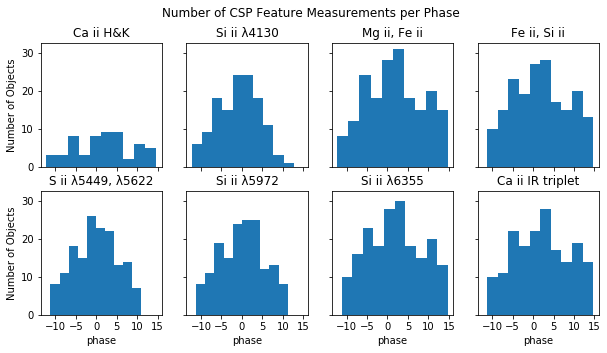

In [12]:
plot_number_feature_measurements(csp_final, 'phase', 5)
plt.gcf().suptitle('Number of CSP Feature Measurements per Phase')


Text(0.5, 0.98, 'Number of SDSS Feature Measurements per Phase')

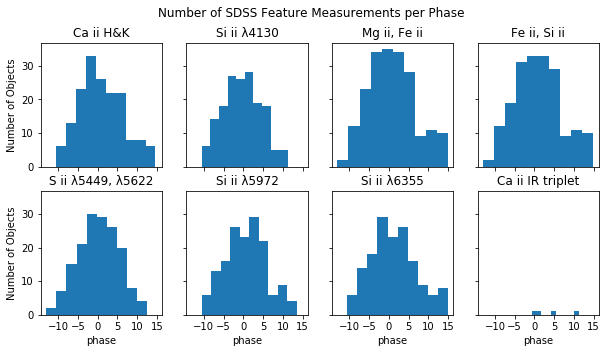

In [13]:
plot_number_feature_measurements(sdss_final, 'phase', 5)
plt.gcf().suptitle('Number of SDSS Feature Measurements per Phase')


Text(0.5, 0.98, 'Number of CSP Feature Measurements')

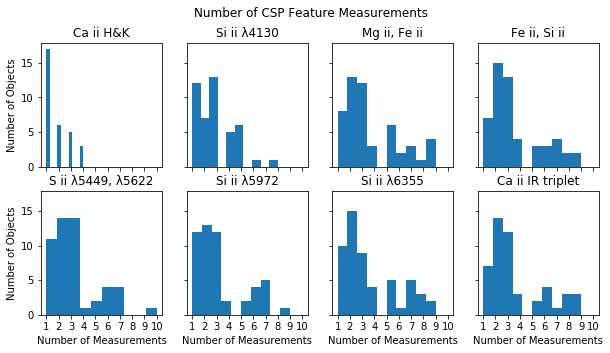

In [14]:
plot_number_feature_measurements(csp_final)
plt.gcf().suptitle('Number of CSP Feature Measurements')


Text(0.5, 0.98, 'Number of SDSS Measurements per Feature')

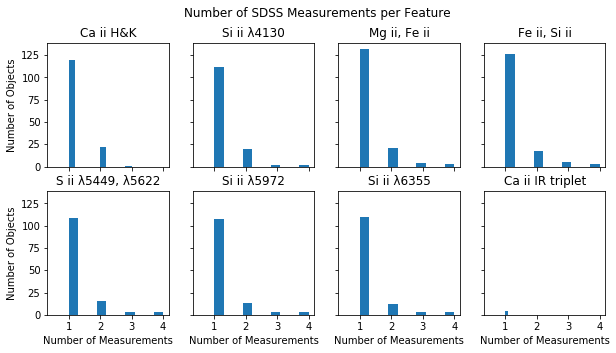

In [15]:
plot_number_feature_measurements(sdss_final)
plt.gcf().suptitle('Number of SDSS Measurements per Feature')


## Effect of Data Cuts

In [16]:
def plot_impact_of_phase_cut(measured_data, cutoff_vals, chosen_cutoff):
    """Plot the cumulative total number of measurements within a given number
    of days from maximum
    
    Args:
        measured_data (DataFrame): The measured data
        cutoff_vals        (List): Values to plot on x-axis in units of days
    """
    
    phase_abs = measured_data.phase.abs()
    
    fig, axis = plt.subplots(figsize=(10, 5))
    for feature, data in phase_abs.groupby(level=0):
        y_vals = [len(data[data <= c].index.unique(level=1)) for c in cutoff_vals]
        y_cutoff = len(data[data <= chosen_cutoff].index.unique(level=1))
        axis.plot(cutoff_vals, y_vals, label=f'{feature} ({y_cutoff})')
    
    axis.axvline(proposed_cutoff, color='k', linestyle='--')
    axis.set_ylabel('Number of Objects')
    axis.set_xlabel('Phase Cutoff')
    axis.set_xlim(min(cutoff_vals), max(cutoff_vals))
    axis.set_ylim(0)
    axis.legend()
        

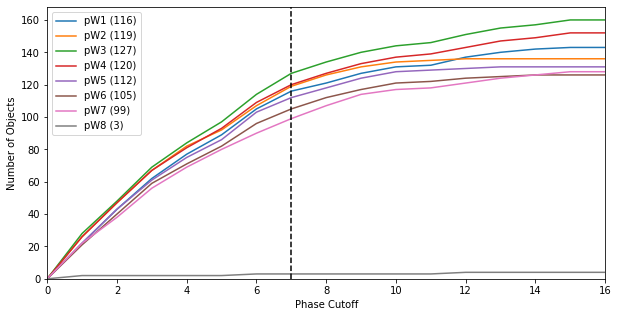

In [17]:
proposed_cutoff = 7
plot_impact_of_phase_cut(sdss_final, np.arange(16, -1, -1), proposed_cutoff)



## Branch Classifications

In [18]:
def plot_branch_classifications(pipeline_data, phase_cutoff=7, figsize=(10, 10)):
    """Create a Branch classification figure
    
    Args:
        pipeline_data (DataFrame): Data that has been read from a pipeline output file
        phase_cutoff      (float): Only use measurements taken within so many days of peak brightness
        fig_size          (Tuple): Size of the figure in inches
    """
    
    fig, axis = plt.subplots(figsize=figsize)
    
    plot_args = {
        'CL': dict(label='Cool', color='blue', marker='s'),
        'BL': dict(label='Broad Line', color='red' , marker='^'),
        'SS': dict(label='Shallow Silicon', color='green' , marker= '*'),
        'CN': dict(label='Core Normal', color='black' , marker= '.')
    }
    peak_vals = pipeline_data[pipeline_data.is_peak]
    peak_vals = peak_vals[peak_vals.delta_t <= phase_cutoff]
    
    pw6_data = peak_vals[['pew', 'pew_samperr', 'branch_type']].loc['pW6']
    all_data = pw6_data.join(peak_vals[['pew', 'pew_samperr']].loc['pW7'], lsuffix='_6', rsuffix='_7').dropna()

    for branch_class, data in all_data.groupby('branch_type'):
        label = plot_args[branch_class].pop('label') + f' ({len(data)})'
        axis.errorbar(
            data.pew_7, 
            data.pew_6, 
            xerr=data.pew_samperr_7,
            yerr=data.pew_samperr_6,
            linestyle='',
            label=label,
            **plot_args.get(branch_class, dict()))
    
    plt.title('Strength of pW6 vs pW7')
    axis.legend(loc = ('upper left'))
    plt.xlabel('pew of pW7')
    plt.ylabel('pew of pW6')
    

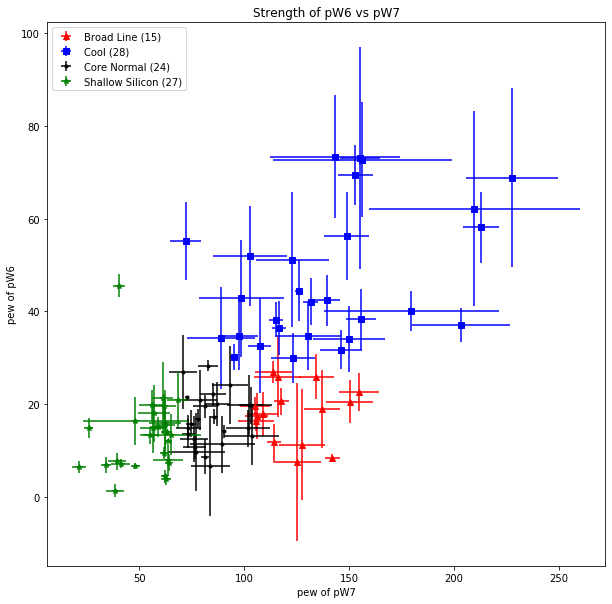

In [19]:
plot_branch_classifications(sdss_final, proposed_cutoff)


## pEW and Velocity Vs. Phase

In [20]:
def plot_feat_evolution(feature_data, plot_col='pew', color_by='spec_type', kwargs=None, axis=None):
    """Plot the strength of a feature vs phase
    
    Args:
        feature_data (DataFrame): Dataframe to plot data from
        plot_col           (str): Column to plot on the y axis 
        color_by           (str): Name of the column to color code points by
        kwargs      (dict[dict]): Plotting kwargs for each unique value in the `color_by` column
        axis              (Axis): Optionally plot on a given axis
    """

    # Set default values
    kwargs = dict() if kwargs is None else kwargs
    if axis is None:
        fig, axis = plt.subplots(figsize=(6, 4))
    
    feature_data = feature_data.sort_values('phase')
    for i, (class_name, class_data) in enumerate(feature_data.groupby(color_by)):
        x = class_data.phase
        y = class_data[plot_col]
        y_err = class_data[plot_col + '_samperr']
        
        plot_kw = kwargs.get(class_name, dict())
        axis.errorbar(x, y, yerr=y_err, linestyle='', **plot_kw)
        axis.scatter(x, y, s=10, label=class_name,  **plot_kw)
    
    if axis is None:
        axis.set_xlabel('Phase', fontsize=12)
        axis.set_ylabel(r'pEW ($\AA$)', fontsize=12)
        
    axis.set_xlim(-15, 15)
    

In [21]:
def plot_all_features(df, plot_col='pew', color_by='spec_type', kwargs=None):
    """Plot pEW measurements vs. phase for all 8 features
    
    Args:
        df      (DataFrame): Dataframe to plot data from
        plot_col      (str): Column to plot on the y axis
        color_by      (str): Name of the column to color code points by
        kwargs (dict[dict]): Plotting kwargs for each unique value in the `color_by` column
    """

    # Set default values
    kwargs = dict() if kwargs is None else kwargs
    plot_features = feature_alias.copy()
    
    fig, axes = plt.subplots(4, 2, sharex=True, figsize=(7.5, 10))
    for axis, feature in zip(axes.flatten(), plot_features):
        axis.set_title(f'{plot_features[feature]} ({feature})')

        feature_data = df.loc[feature]
        plot_feat_evolution(
            feature_data, plot_col=plot_col,
            color_by=color_by, axis=axis, kwargs=kwargs)
        
    for axis in axes[:, 0]:
        axis.set_ylabel(plot_col, fontsize=12)
    
    for axis in axes[-1, :]:
        axis.set_xlabel('Phase', fontsize=12)
        
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), framealpha=1, bbox_to_anchor=(1.15, 1))
    
    plt.tight_layout()
    

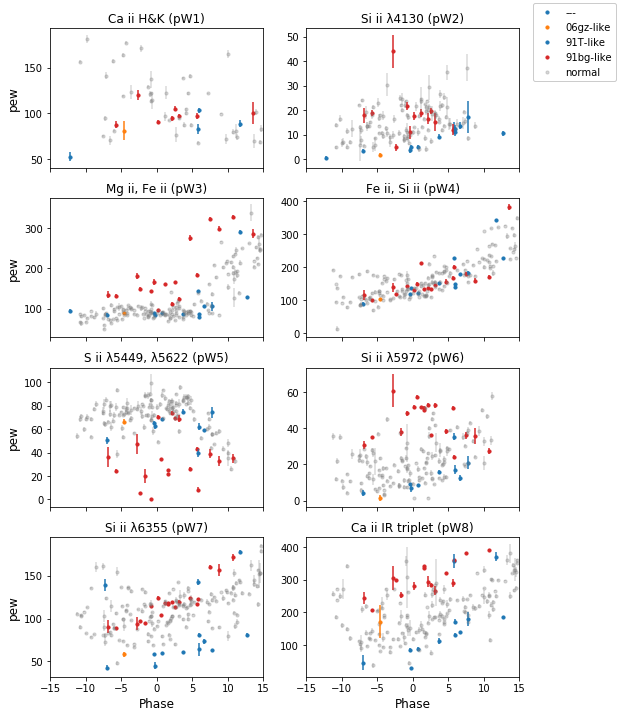

In [22]:
csp_kwargs = {
    'normal': {'color': 'grey', 'alpha': .3},
    '91bg-like': {'color': 'C3'},
    '91T-like': {'color': 'C0'},
    '06gz-like': {'color': 'C1'}
}

plot_all_features(csp_final, kwargs=csp_kwargs, color_by='spec_type')
plt.savefig(fig_dir / 'csp_pew.pdf')


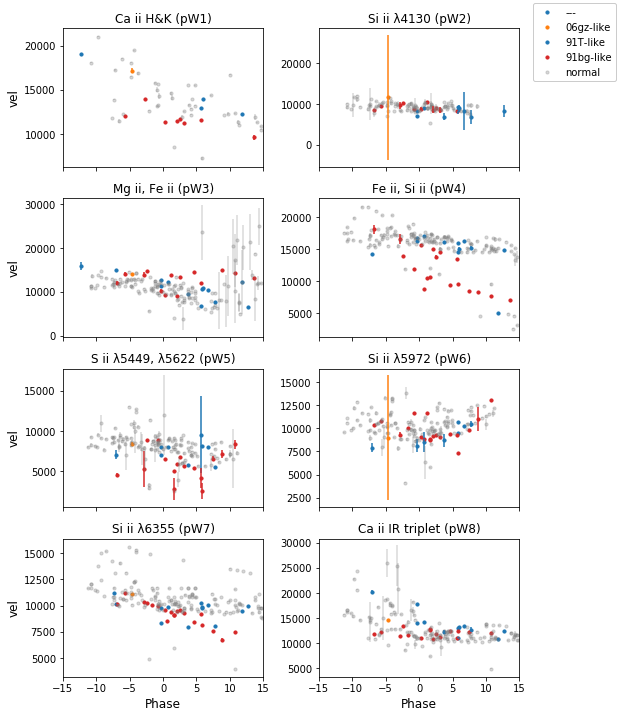

In [23]:
plot_all_features(csp_final, 'vel',  kwargs=csp_kwargs, color_by='spec_type')
plt.savefig(fig_dir / 'csp_vel.pdf')


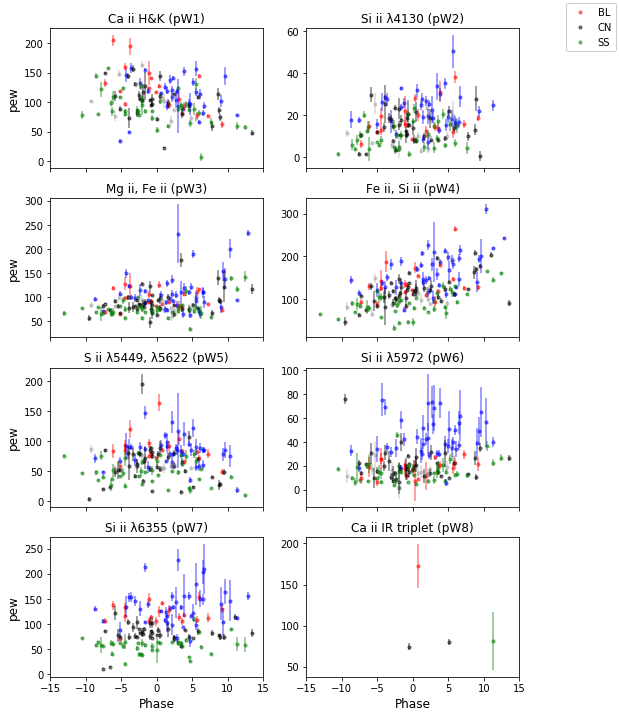

In [66]:
sdss_kwargs = {
    'BL': {'color': 'red', 'alpha': .5},
    'SS': {'color':'green', 'alpha': .5},
    'CL':{'color':'blue', 'alpha': .5},
    'CN':{'color':'black', 'alpha': .5},
    'unknown': {'color': 'grey', 'alpha': .3}
}

plot_all_features(sdss_final, kwargs=sdss_kwargs, color_by='branch_type')
plt.savefig(fig_dir / 'sdss_pew.pdf')


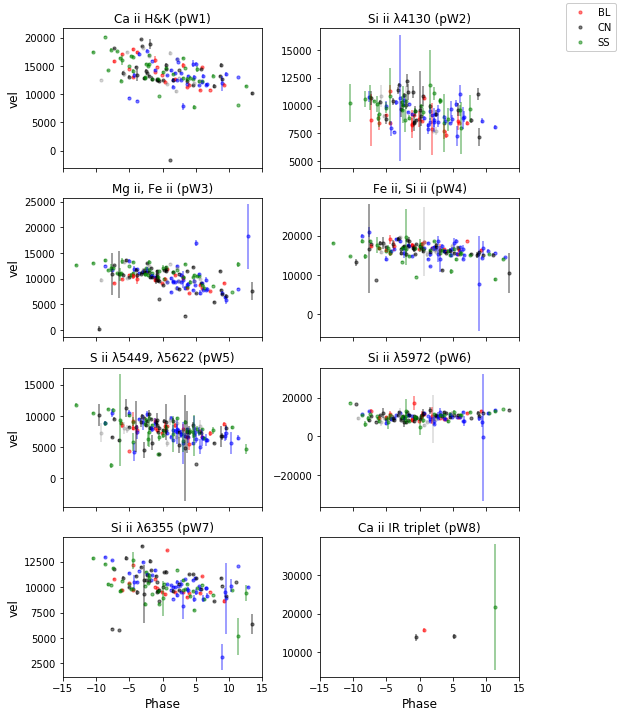

In [67]:
plot_all_features(sdss_final, 'vel', kwargs=sdss_kwargs, color_by='branch_type')
plt.savefig(fig_dir / 'sdss_vel.pdf')


## Host Galaxy Trends

In [36]:
def create_corner_hist_figure(
    num_subfigs=8, subfigs_per_row=2, fig_size=(6.5, 9), xlabel=None, ylabel=None, vspace=.15, hspace=.15
):
    """Create a figure containing axes for multiple scatter plots with bordering histograms
    
    Args:
        num_subfigs     (int): Number of axes to make for scatter plots
        subfigs_per_row (int): Number of Scatter plot axes per row
        fig_size      (Tuple): The size of the figure
        x_label         (str): x-label to use for the figure
        ylabel          (str): y-label to use for the figure
        
    Returns:
        The matplolib figure
        An array of axes for scatter plots
        An array of axes for x-axis histograms
        An array of axes for y-axis histograms
    """
    
    # Calculate the number and relative width of each column
    columns_per_feature = 3
    num_columns = (subfigs_per_row * columns_per_feature) - 1

    histogram_width = .5
    width_ratios = np.ones(num_columns)
    width_ratios[2::3] = hspace
    width_ratios[1::3] = histogram_width
    width_ratios /= sum(width_ratios)

    # Calculate the number and relative height of each row
    rows_per_feature = 3
    num_rows = int(np.ceil(num_subfigs / subfigs_per_row * rows_per_feature)) - 1

    spacer_height = .15
    histogram_height = .5
    height_ratios = np.ones(num_rows)
    height_ratios[0::3] = histogram_height
    height_ratios[2::3] = vspace
    height_ratios /= sum(height_ratios)

    # Create all subplots. We'll go in and hide the spacer subplots after
    fig, axes = plt.subplots(
        num_rows, num_columns,
        figsize=fig_size,
        gridspec_kw={'width_ratios': width_ratios, 'height_ratios': height_ratios, 'hspace': 0, 'wspace': 0})

    # Hide spacer columns
    for axis in axes[:, 2::columns_per_feature].flatten():
        axis.set_visible(False)

    # Hide spacer rows
    for axis in axes[2::rows_per_feature].flatten():
        axis.set_visible(False)

    # Hide axes in the corner formed by histogram subplots
    for axis in axes[0::rows_per_feature, 1::columns_per_feature].flatten():
        axis.set_visible(False)

    scatter_axes = axes[1::rows_per_feature, 0::columns_per_feature].flatten()
    vertical_hist = axes[1::rows_per_feature, 1::columns_per_feature].flatten()
    horizontal_hist = axes[0::rows_per_feature, 0::columns_per_feature].flatten()
    for sax, vax, hax in zip(scatter_axes, vertical_hist, horizontal_hist):
        sax.sharex = hax 
        sax.sharey = vax 
        
    # Assign labels
    for axis in axes[1::rows_per_feature, 0].flatten():
        axis.set_ylabel(ylabel)
        
    for axis in axes[-1, 0::columns_per_feature].flatten():
        axis.set_xlabel(xlabel)
        
    
    return fig, scatter_axes, horizontal_hist, vertical_hist


In [150]:
def plot_scatter_hist(data, features, xcol, ycol, yerrcol=None, xlabel=None, ylabel=None, figsize=None):
    """Create scatter plots with bordering histograms
    
    One scatter plot is created for each of the specified features
    
    Args:
        data     (DataFrame): The data to plot
        features (List[str]): The feature ids to plot
        xcol           (str): Name of the column to plot along the x-axis
        ycol           (str): Name of the column to plot along the y-axis
        xlabel         (str): Optional x label (defaults to same value as xcol)
        ylabel         (str): Optional x label (defaults to same value as ycol)
    """
    
    fig, *axes = create_corner_hist_figure(
        num_subfigs=len(features), 
        fig_size=figsize or (10, 20),
        vspace=.2,
        xlabel=xcol if xlabel is None else xlabel,
        ylabel=ycol if ylabel is None else ylabel)

    for feat, scatter_ax, horizontal_ax, vertical_ax in zip(features, *axes):
        feat_data = data.loc[feat]
        x = feat_data[xcol]
        y = feat_data[ycol]
        
        if yerrcol:
            scatter_ax.errorbar(x, y, feat_data[yerrcol], linestyle='', alpha = 0.3)
        
    
            color_data = feat_data.copy()
            color_data = color_data.reset_index()
            #color_data = color_data.dropna(subset = ['branch_type'])
            #df['DataFrame Column'] = df['DataFrame Column'].fillna(0)
            color_data['branch_type'] = color_data['branch_type'].fillna('unknown')
            color_data = color_data.branch_type.map(dict(BL='red', SS='green', CL='blue', CN='black', unknown='grey', nan = 'grey'))
            color_data = color_data.values
            scatter_ax.scatter(x, y, s=8, c=color_data, alpha=0.7)
            horizontal_ax.hist(x)
            vertical_ax.hist(y, orientation='horizontal')
            
            #scatter_ax.errorbar(x, y, feat_data[yerrcol], linestyle='', c=color_data)
        
        no_nan = (np.isfinite(x) & np.isfinite(y))
        corr, p = pearsonr(x[no_nan], y[no_nan])
        horizontal_ax.set_title(f'c={corr:.2f} p={p: .4f}')


In [151]:
temp_df = sdss_final.copy()
temp_df['delta_t'] = temp_df.phase.abs()
temp_df = temp_df[temp_df.delta_t <= proposed_cutoff]
temp_df = temp_df.sort_values('delta_t')
temp_df[~temp_df.index.duplicated()]

sako_master = sako_18_spec.load_table('master').to_pandas()
sako_master = sako_master.rename({'CID': 'obj_id'}, axis='columns')
sako_master['obj_id'] = sako_master.obj_id.astype(int)
sako_master = sako_master.set_index('obj_id')

sdss_combined = temp_df.join(sako_master, how='inner')
sdss_combined['branch_type']

feat_name  obj_id
pW6        19128      BL
pW7        2017       SS
pW5        2017       SS
pW6        2017       SS
pW4        19128      BL
                    ... 
pW1        19968      SS
pW2        19968      SS
pW1        8719      NaN
pW3        8719      NaN
pW2        8719      NaN
Name: branch_type, Length: 956, dtype: object

# redshift

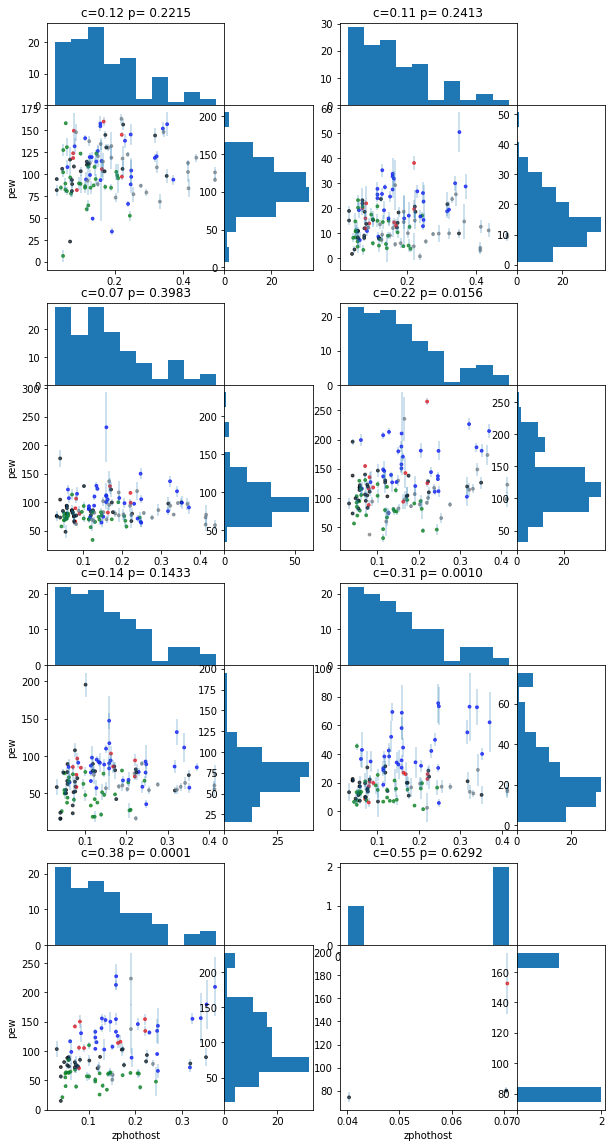

In [152]:
#KF, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'zphothost', 
    'pew', 
    'pew_samperr')


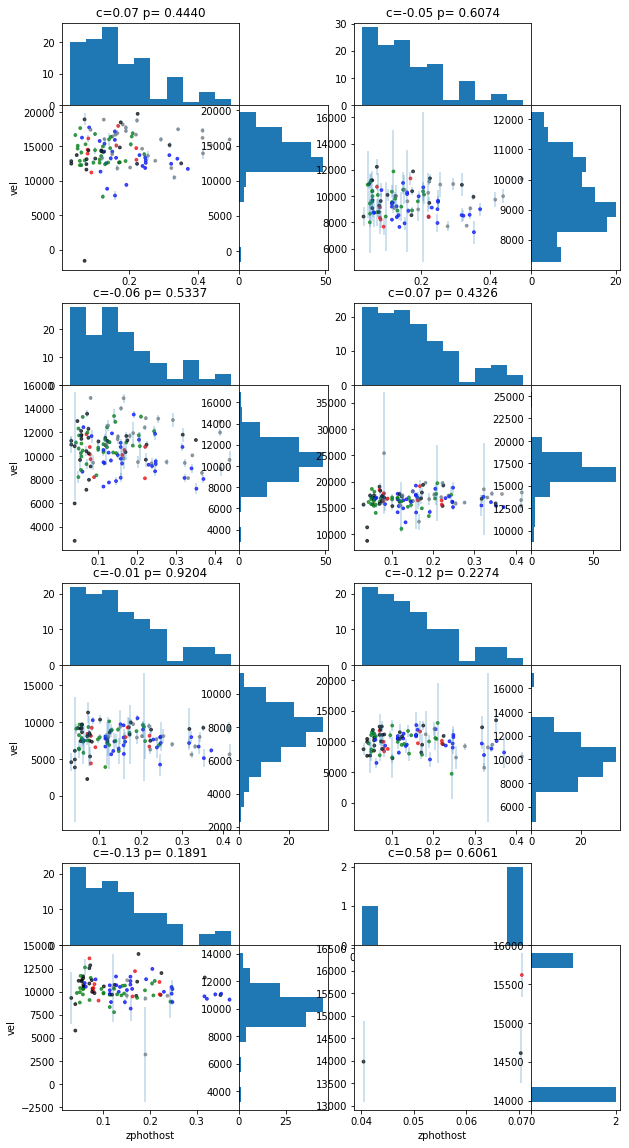

In [153]:
#KF, velocity
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'zphothost', 
    'vel', 
    'vel_samperr')

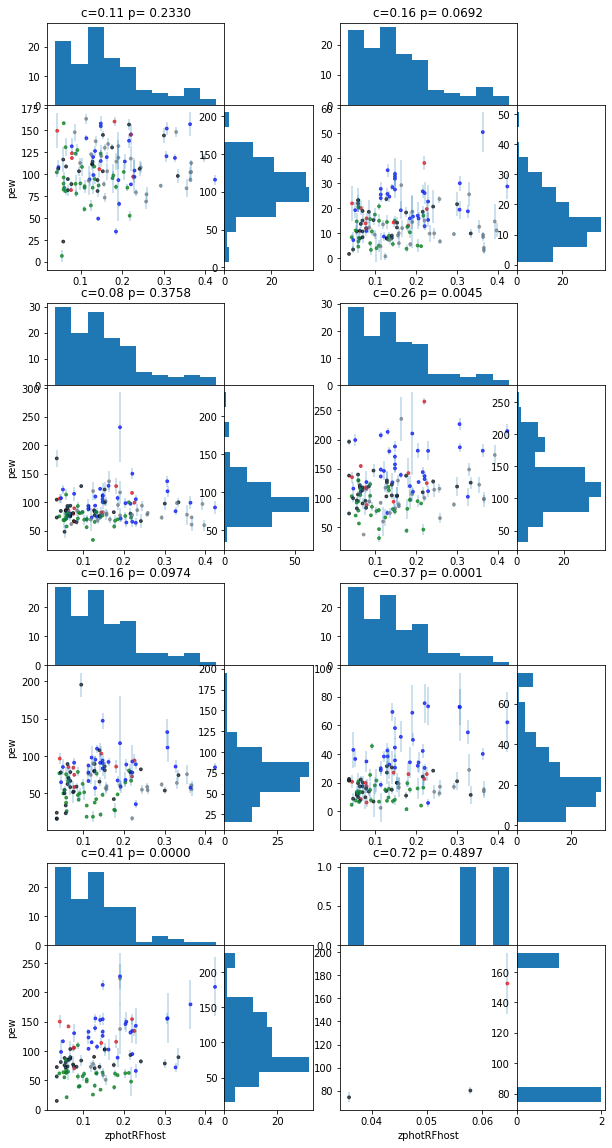

In [154]:
#RF, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'zphotRFhost', 
    'pew', 
    'pew_samperr')

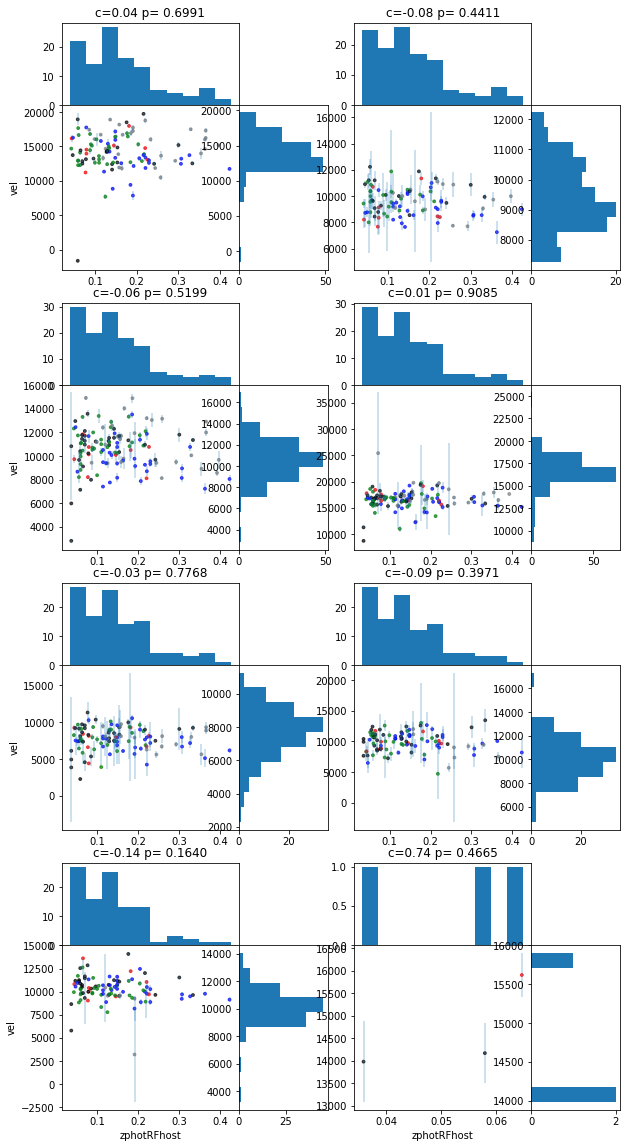

In [155]:
#RF, vel
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'zphotRFhost', 
    'vel', 
    'vel_samperr')

# host mass

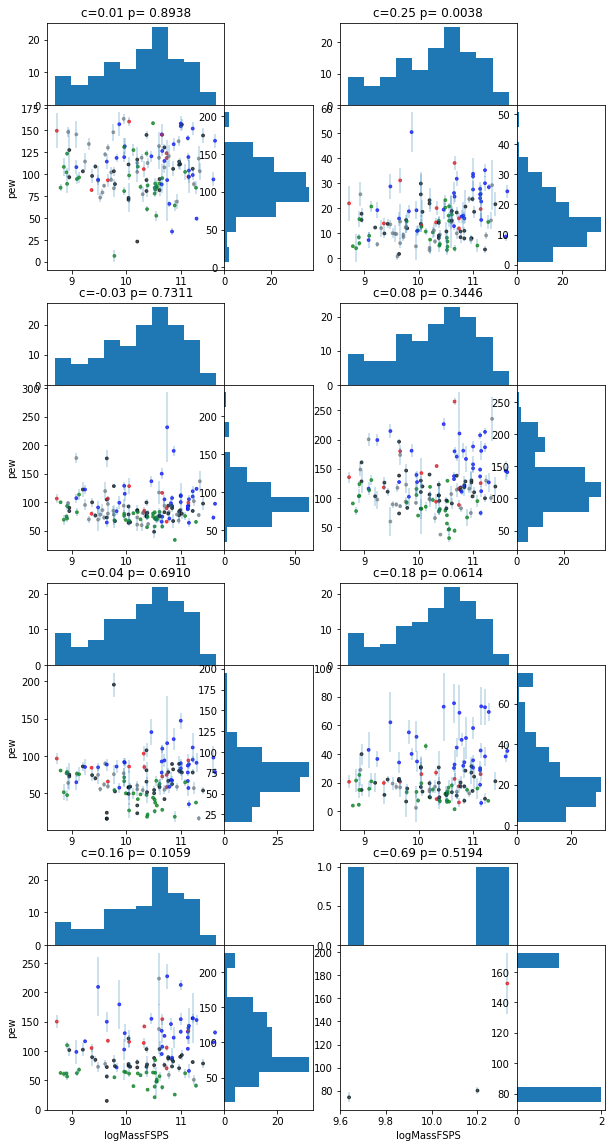

In [156]:
# FSPS, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'logMassFSPS', 
    'pew', 
    'pew_samperr')

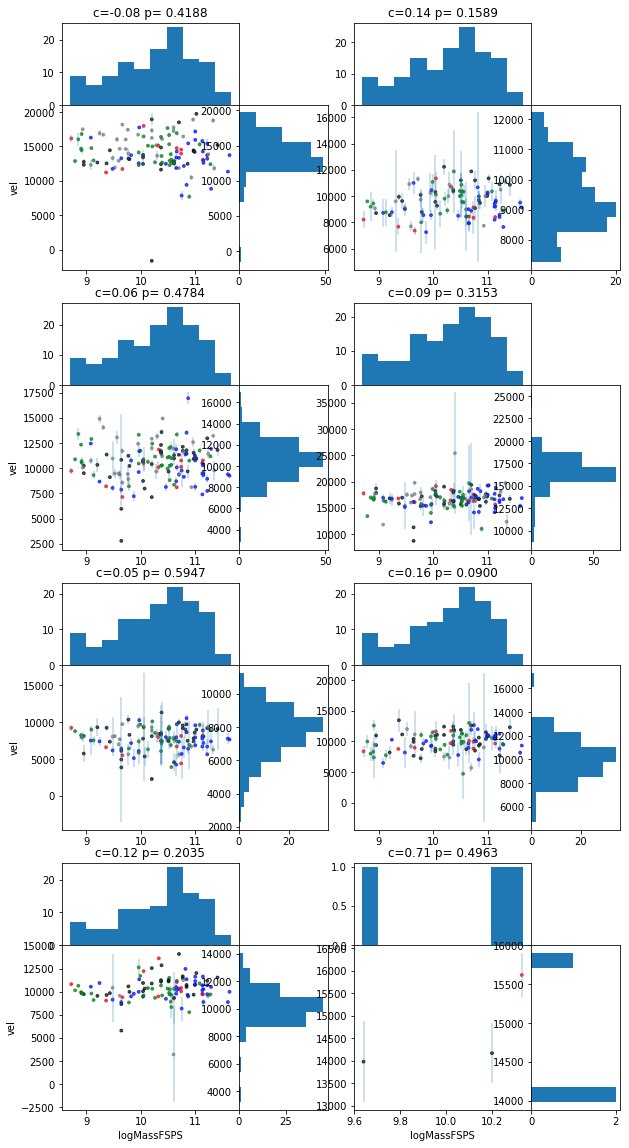

In [157]:
#FSPS, vel
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'logMassFSPS', 
    'vel', 
    'vel_samperr')

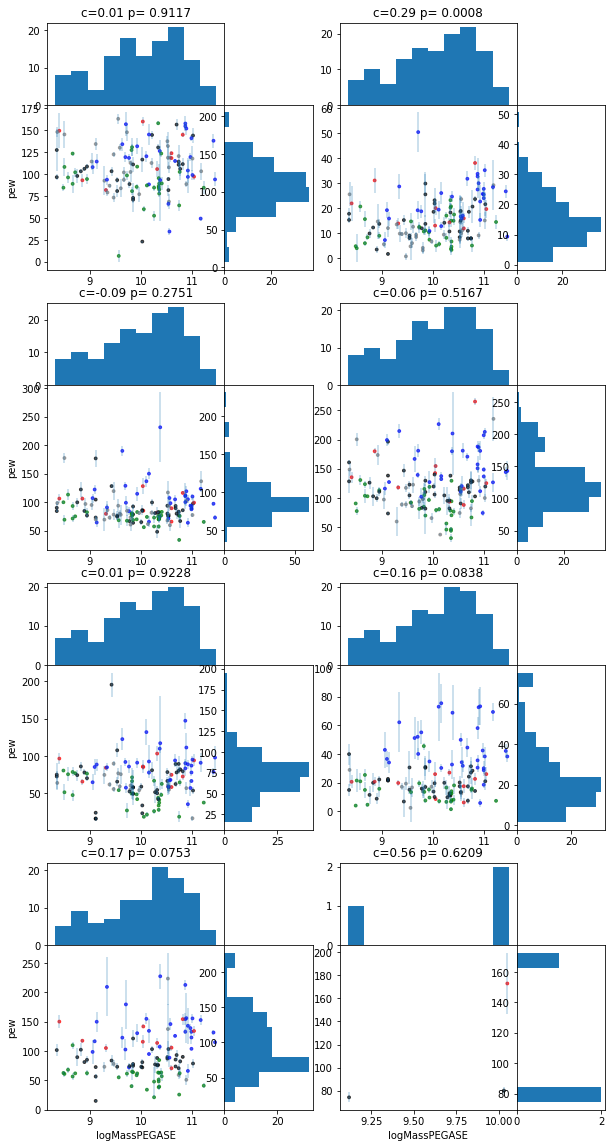

In [158]:
# PEGASE, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'logMassPEGASE', 
    'pew', 
    'pew_samperr')

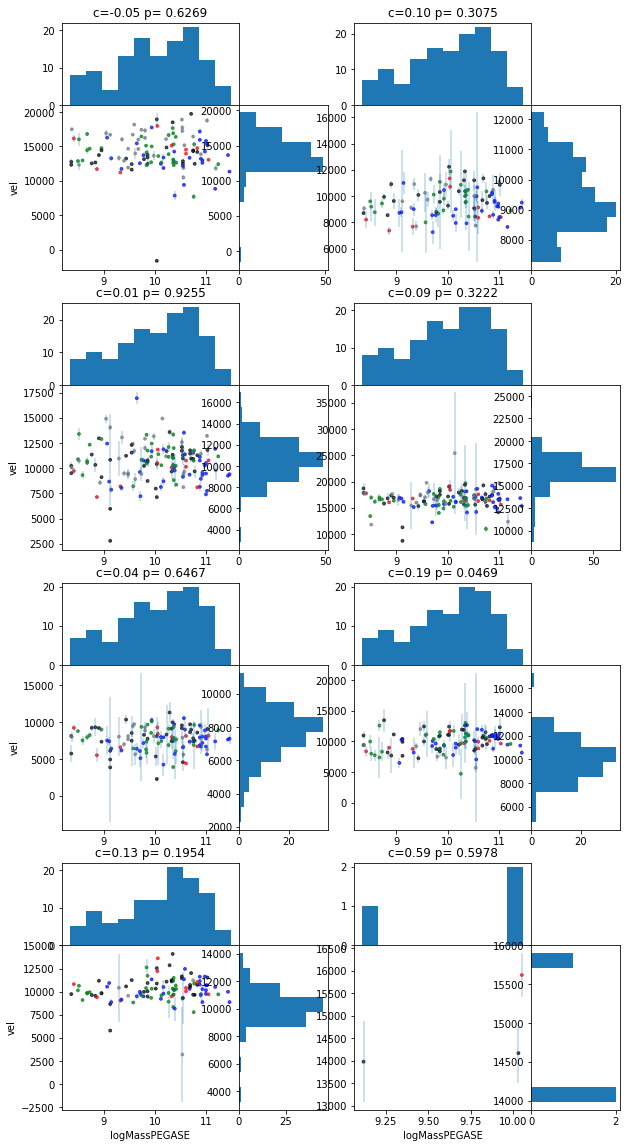

In [159]:
# PEGASE, vel
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'logMassPEGASE', 
    'vel', 
    'vel_samperr')

# SFR

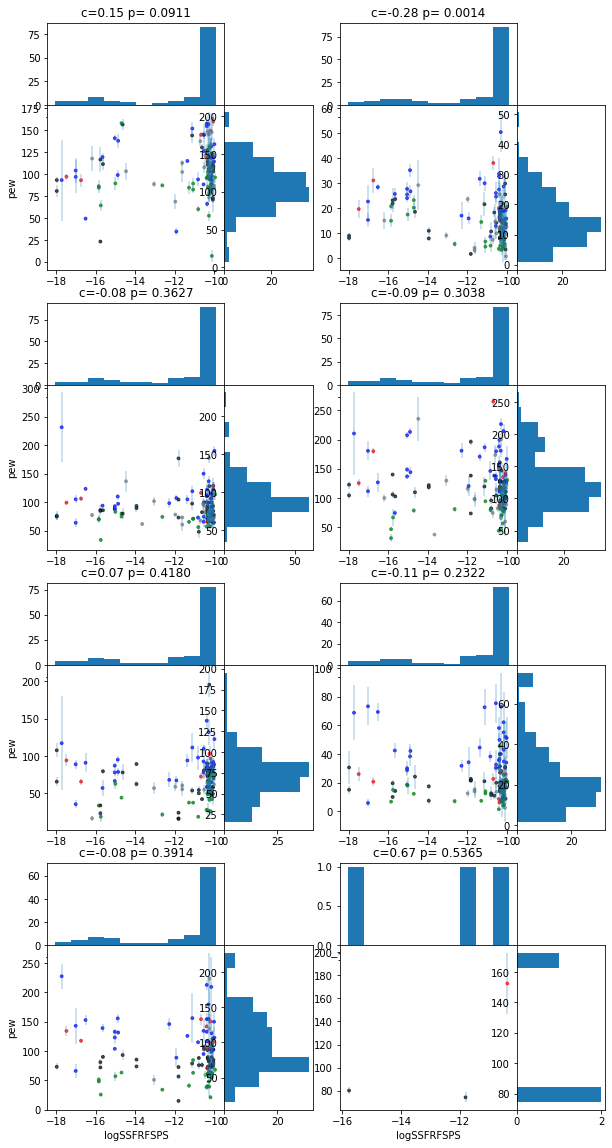

In [160]:
#FSPS, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'logSSFRFSPS', 
    'pew', 
    'pew_samperr')

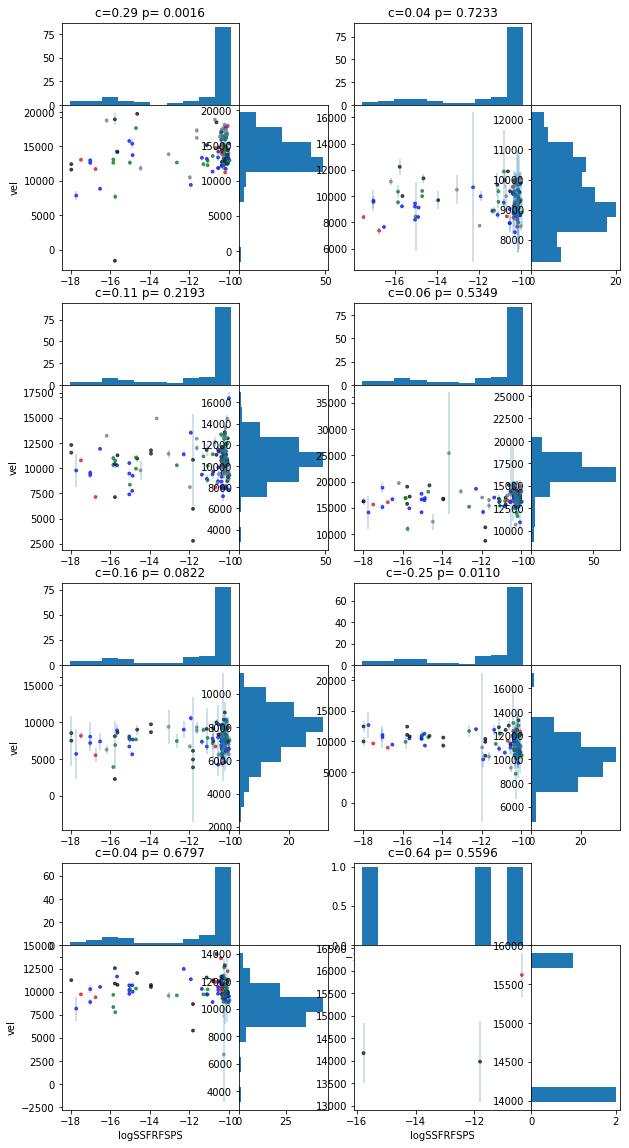

In [161]:
#FSPS, vel
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'logSSFRFSPS', 
    'vel', 
    'vel_samperr')

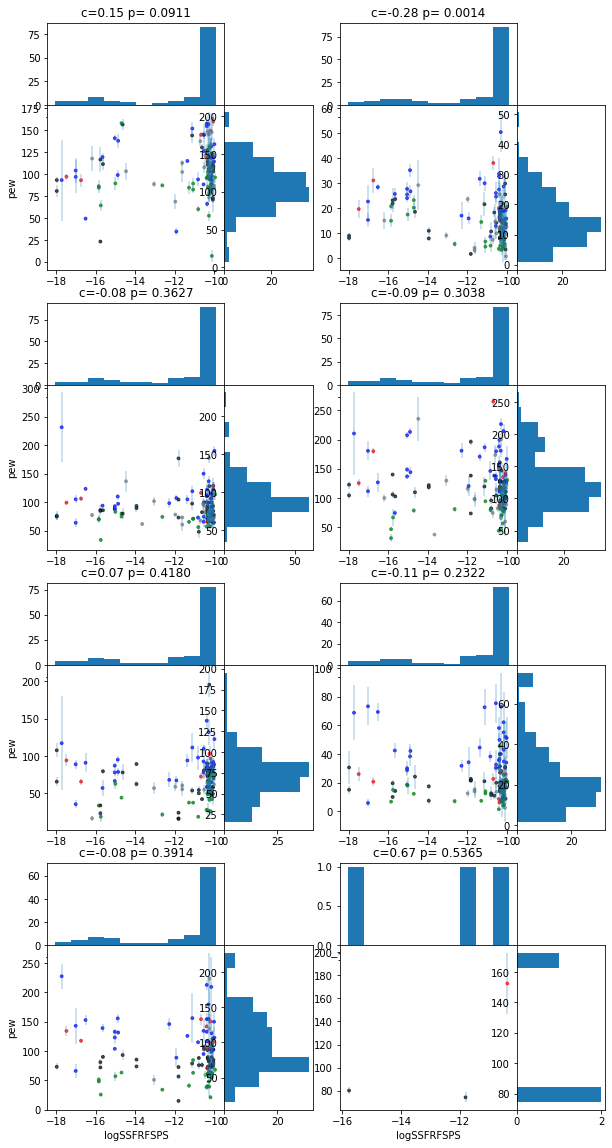

In [162]:
# FSPS, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'logSSFRFSPS', 
    'pew', 
    'pew_samperr')

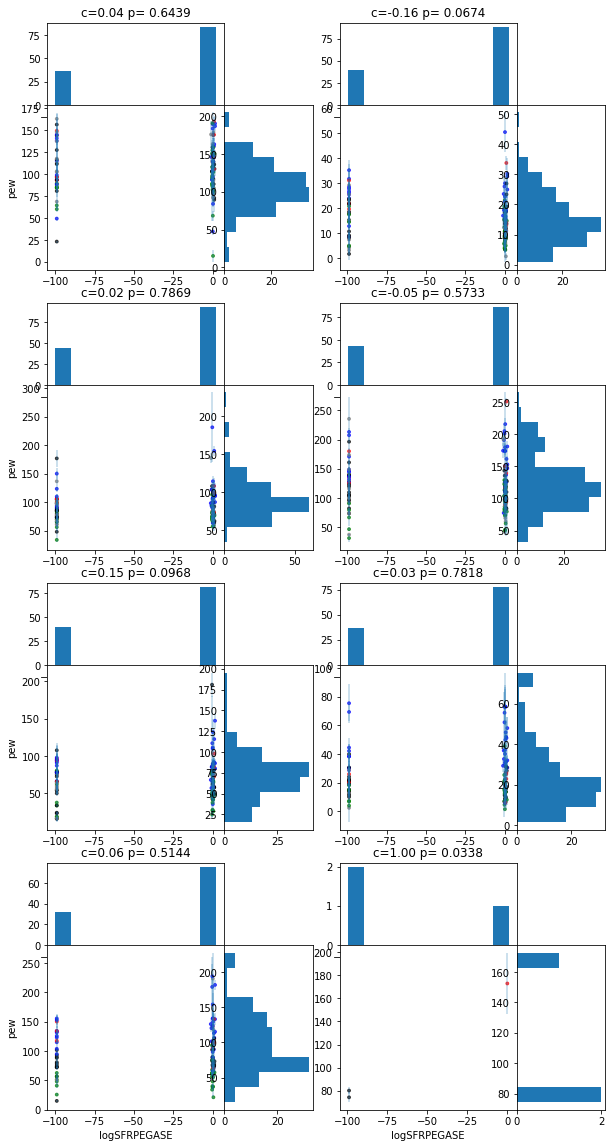

In [163]:
#PEGASE, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'logSFRPEGASE', 
    'pew', 
    'pew_samperr')

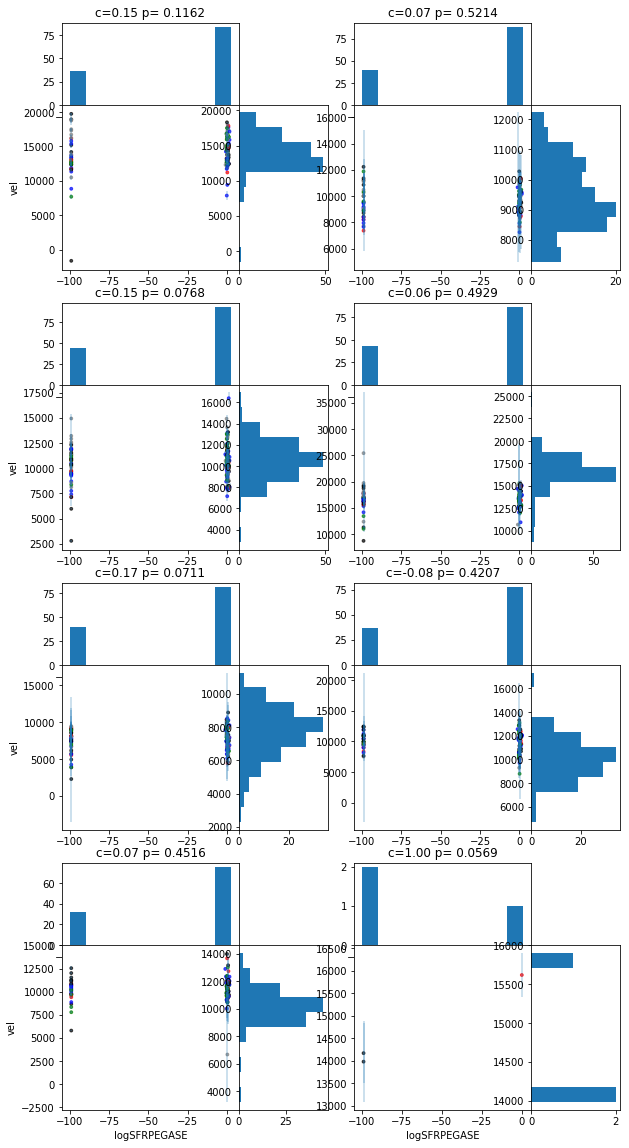

In [164]:
#PEGASE, vel
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'logSFRPEGASE', 
    'vel', 
    'vel_samperr')

# Age

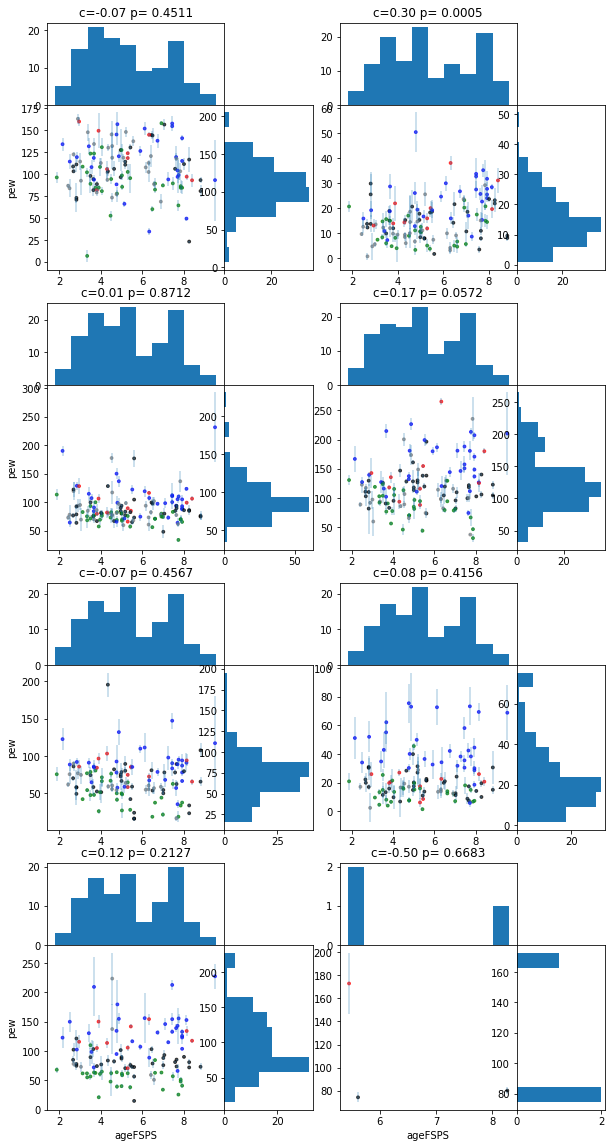

In [165]:
#FSPS, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'ageFSPS', 
    'pew', 
    'pew_samperr')

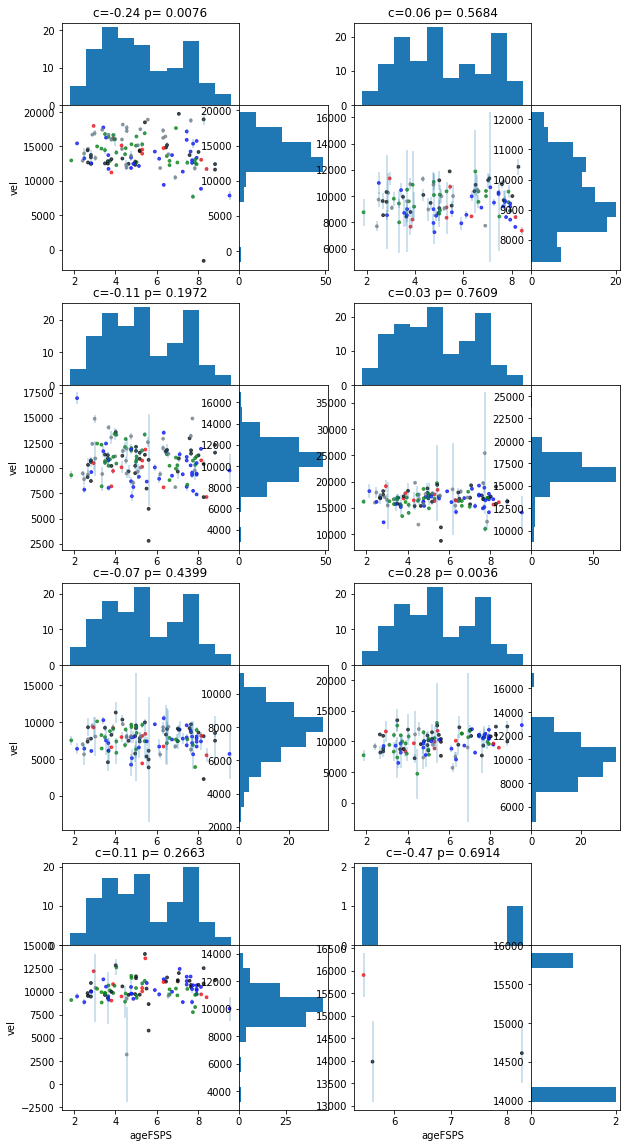

In [166]:
#FSPS, vel
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'ageFSPS', 
    'vel', 
    'vel_samperr')

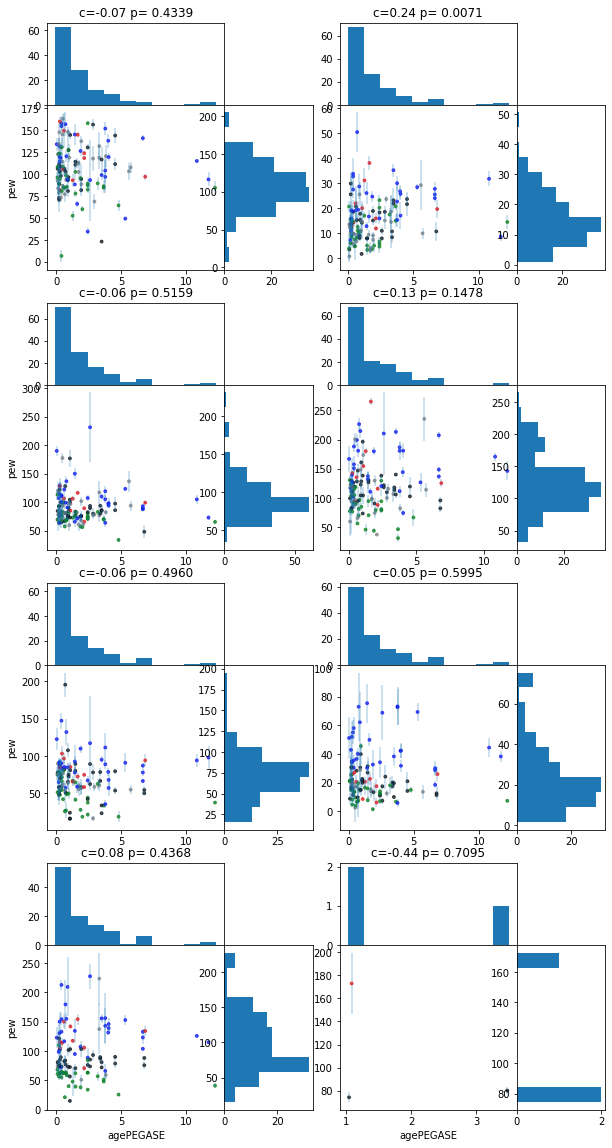

In [167]:
#PEGASE, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'agePEGASE', 
    'pew', 
    'pew_samperr')

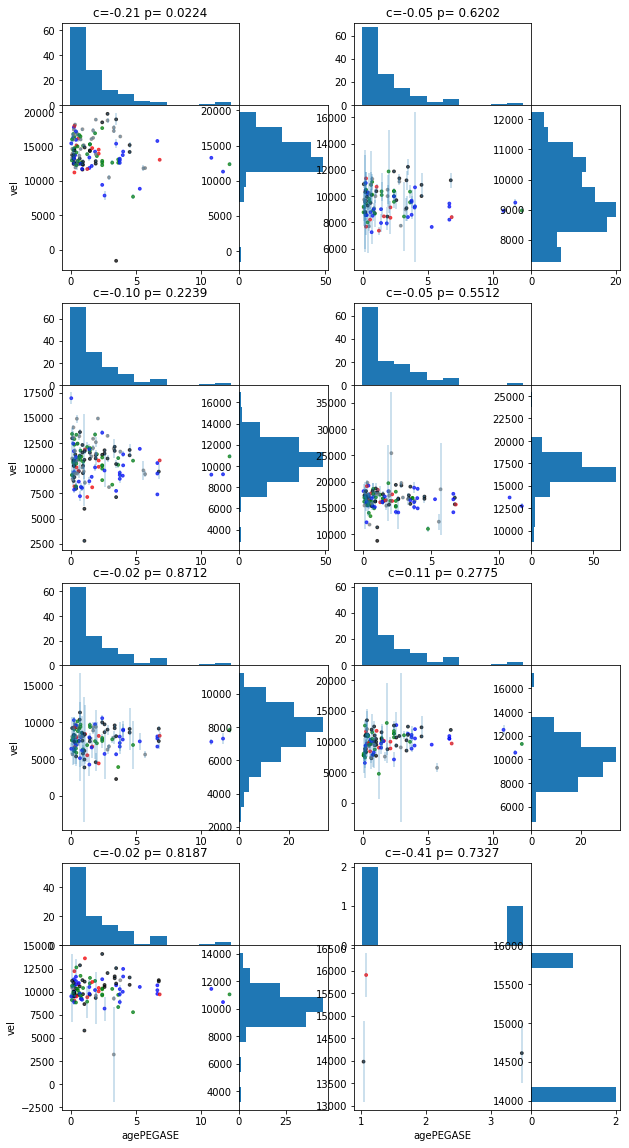

In [168]:
#PEGASE, vel
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'agePEGASE', 
    'vel', 
    'vel_samperr')

# vel

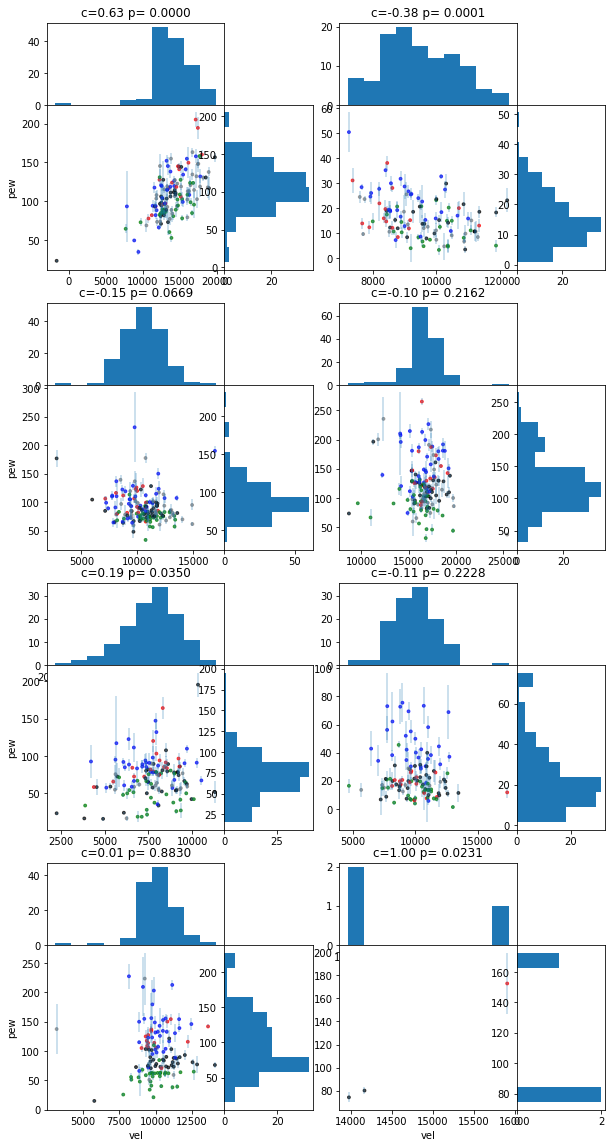

In [169]:
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'vel', 
    'pew', 
    'pew_samperr')

# distance from SN to host reg, norm

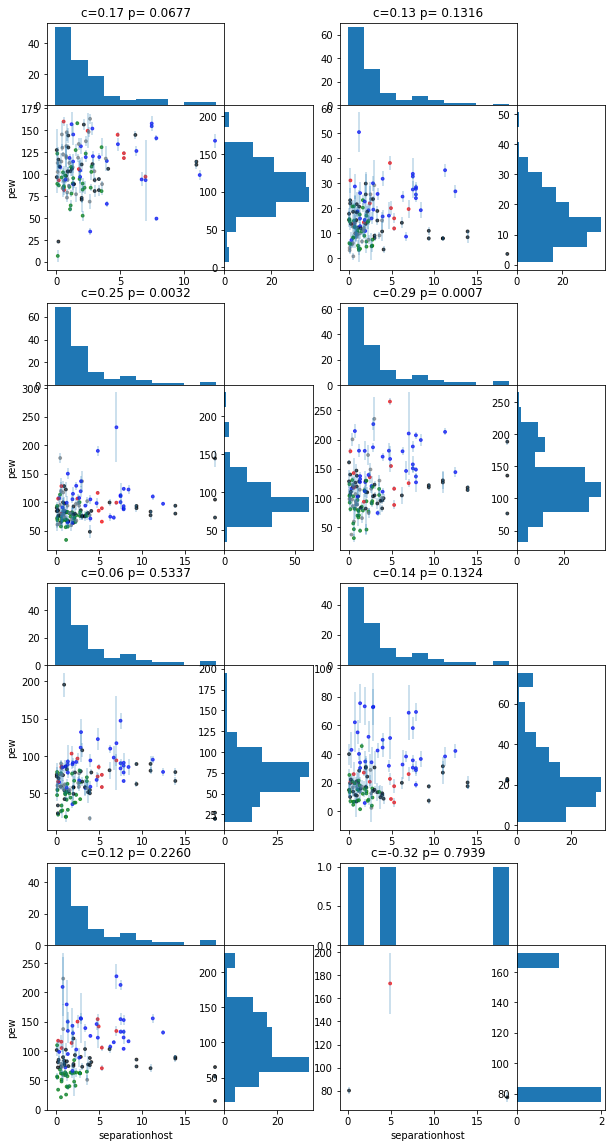

In [170]:
#not normalized, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'separationhost', 
    'pew', 
    'pew_samperr')

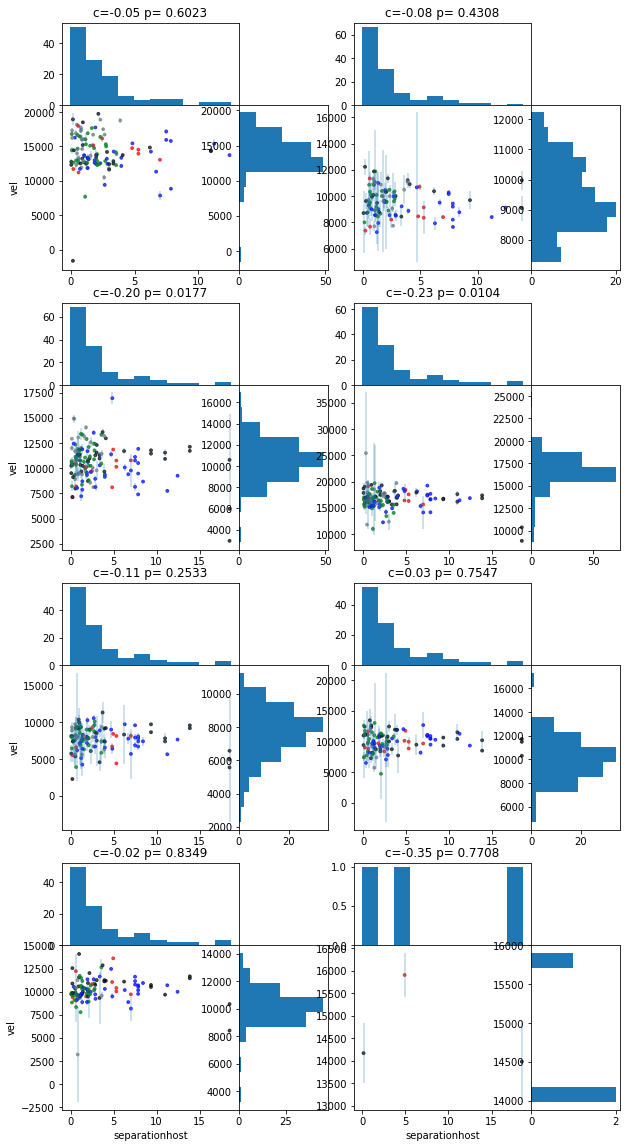

In [171]:
#not normalized, vel
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'separationhost', 
    'vel', 
    'vel_samperr')

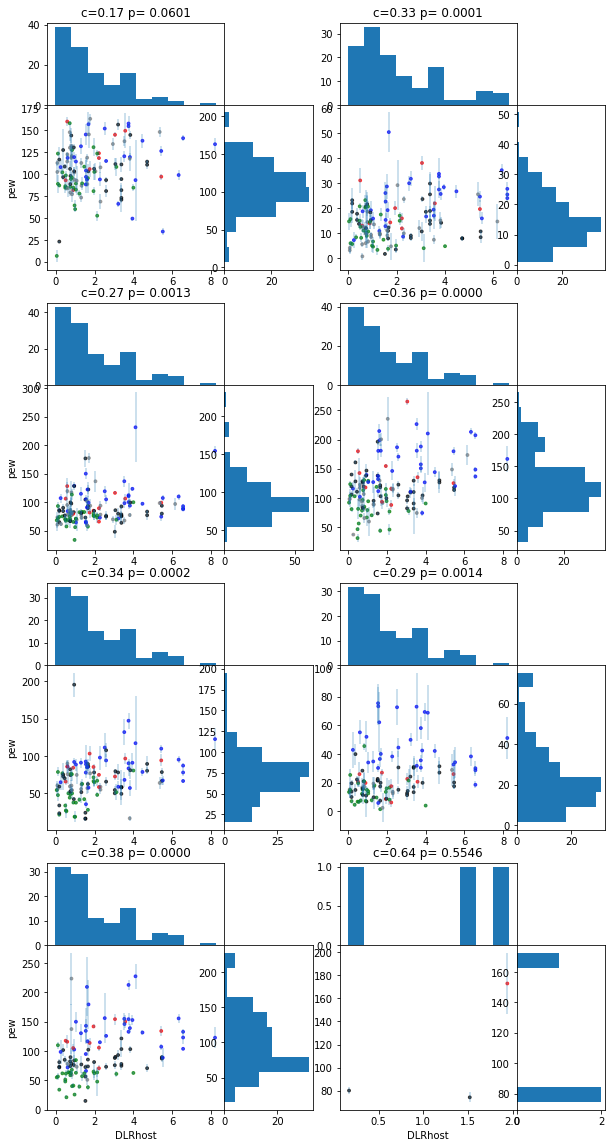

In [172]:
#normalized, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'DLRhost', 
    'pew', 
    'pew_samperr')

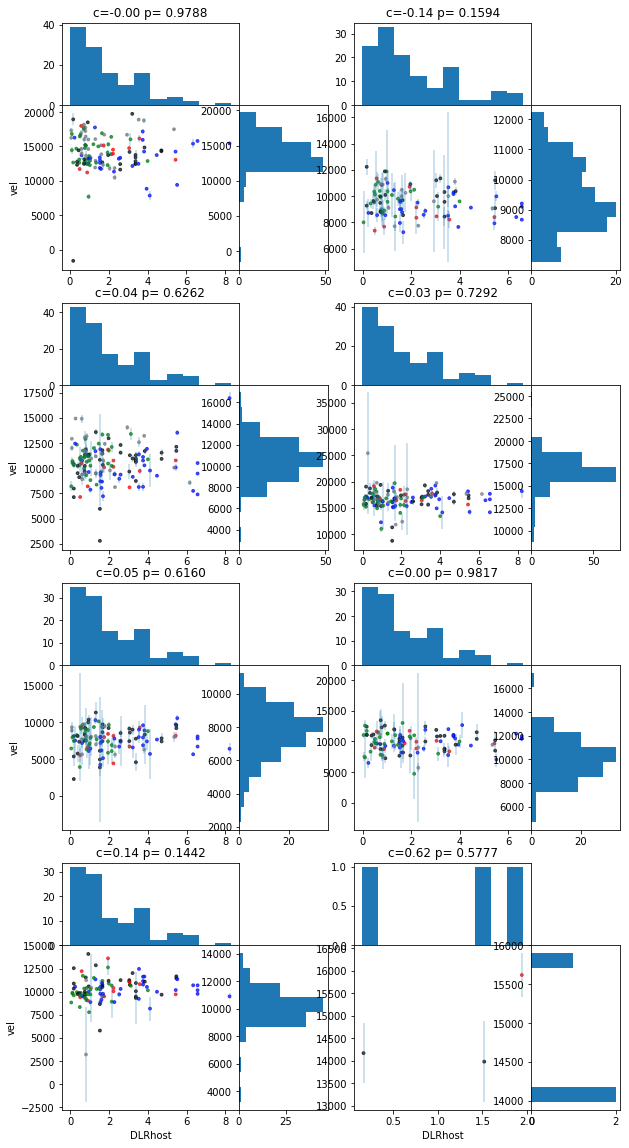

In [173]:
#normalized, vel
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'DLRhost', 
    'vel', 
    'vel_samperr')